# Initial EDA for Senior Thesis

## Dependencies

In [55]:
# libraries that I may potential need:
import pandas as pd
import math
import time
import os
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import rasterio.warp
from rasterio.windows import from_bounds
from rasterio.warp import transform_bounds
import geopandas as gpd
from shapely.geometry import Point, box
from pandas.plotting import scatter_matrix

## Variables

### Used Google Translate to reencocde variable names:
| original variable name | translated variable name |
| --- |--- |
| gattung_botanisch  | botanical genus     |
| gattung_deutsch    | German genus        |
| art_botanisch      | botanical species   |
| art_deutsch        | German species      |
| alleebaum          | avenue tree         |
| hoehe              | height              |
| stammdurchmesser   | trunk diameter      |
| stammumfang        | trunk circumference |
| kronendurchmesser  | crown diameter      |
| baumpatenschaft    | tree sponsorship    |

In [56]:
# set path to data set
path = '../data/data_gov_de/trees/baeume.json'

# create german to english variable name map
recoded_column_names = {
    'gattung_botanisch' : 'botanical_genus'     ,
    'gattung_deutsch'   : 'German_genus'        ,
    'art_botanisch'     : 'botanical_species'   ,
    'art_deutsch'       : 'German-species'      ,
    'alleebaum'         : 'avenue_tree'         ,
    'hoehe'             : 'height'              ,
    'stammdurchmesser'  : 'trunk_diameter'      ,
    'stammumfang'       : 'trunk_circumference' ,
    'kronendurchmesser' : 'crown_diameter'      ,
    'baumpatenschaft'   : 'tree_sponsorship'    ,
    }

## Functions

In [57]:
def list_printer(a_list:list, number_of_items_to_print:int = 10000, span:int=80):
    """
    # Formated list printer
    ## Expects: 
     - A list like object
     - number of items from list to print. Default 10000
     - max length of page in. Assumes terminal is using fixed width font. Default 80
    ## Returns: Prints a formated list.
    """
    counter = 1
    list_len = len(a_list)
    max_len = len(max(a_list, key=len)) + 2
    if span > max_len:
        cols = round(span / max_len )
    else: return f'span {span} must be greater than len of longest item in list {max_len} +2'
    for i in a_list:
        if counter > number_of_items_to_print:
            break
        elif counter % cols == 0:
            print(f'{i:^{max_len}}')
        else: 
            print(f'{i:^{max_len}}', end= ' | ')
        counter += 1

## Load and Inspect data

In [58]:
# read GeoJson data into a GeoPandas DF
gdf = gpd.read_file(path, encoding='utf-8')

# map translated variable names
gdf = gdf.rename(columns=recoded_column_names)
gdf.head()

# inspect head
gdf.head()

,uuid,botanical_genus,German_genus,botanical_species,German-species,avenue_tree,height,trunk_diameter,trunk_circumference,crown_diameter,tree_sponsorship,geometry
0,fa3c43ce-8e5f-46e6-ac9d-aa950bf0f4a9,Acer,Ahorn,Acer species,Ahorn,False,10.0,20.37,64.0,5.0,False,POINT (12.11649 54.06367)
1,1140029d-8c75-47c4-ace0-19ac0ed66410,Acer,Ahorn,Acer species,Ahorn,False,14.0,42.65,134.0,10.0,False,POINT (12.04897 54.14658)
2,67e8b1df-0c5a-48b8-bd86-a8b5c126f6e3,Acer,Ahorn,Acer species,Ahorn,False,12.0,28.97,91.0,7.0,False,POINT (12.04912 54.14656)
3,b3663402-c4c7-49f0-9c9e-79f01f5c378a,Acer,Ahorn,Acer species,Ahorn,False,9.0,37.24,117.0,9.0,False,POINT (12.04819 54.14642)
4,09981ce2-fcc4-48c7-a390-8c2135071f00,Prunus,Kirsche,Prunus species,Kirsche,False,8.0,32.79,103.0,7.0,False,POINT (12.0475 54.14627)


In [59]:
# summarize
gdf.describe()

,height,trunk_diameter,trunk_circumference,crown_diameter
count,69485.000000,69327.000000,69327.000000,69391.000000
mean,12.725637,34.108017,107.153498,6.631641
std,8.557337,24.995161,78.524687,4.955328
min,0.500000,0.250000,0.800000,0.100000
25%,7.000000,18.140000,57.000000,4.000000
50%,11.000000,29.920000,94.000000,6.000000
75%,17.000000,44.880000,141.000000,9.000000
max,915.000000,2588.000000,8130.440000,812.000000


In [60]:
# check for indications of missing data.
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 70606 entries, 0 to 70605
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   uuid                 70606 non-null  object  
 1   botanical_genus      70606 non-null  object  
 2   German_genus         70606 non-null  object  
 3   botanical_species    70606 non-null  object  
 4   German-species       70606 non-null  object  
 5   avenue_tree          70606 non-null  bool    
 6   height               69485 non-null  float64 
 7   trunk_diameter       69327 non-null  float64 
 8   trunk_circumference  69327 non-null  float64 
 9   crown_diameter       69391 non-null  float64 
 10  tree_sponsorship     70606 non-null  bool    
 11  geometry             70606 non-null  geometry
dtypes: bool(2), float64(4), geometry(1), object(5)
memory usage: 5.5+ MB


In [61]:
# collect unique genuses
genus = gdf['botanical_genus'].unique().tolist()
list_printer(genus, number_of_items_to_print=20, span=150)

      Acer       |      Prunus      |      Betula      |      Ulmus       |      Salix       |      Sorbus      |      Pinus       |      Picea       |     Fraxinus    
     Tilia       |     Species      |      Malus       |   Gruppenbäume   |     Viburnum     |     Populus      |     Quercus      |     Carpinus     |      Abies      
     Pyrus       |      Fagus       | 

In [62]:
# collect unique species
species = gdf['botanical_species'].unique().tolist()
list_printer(species, number_of_items_to_print=10, span=150)

                 Acer species                   |                 Prunus species                  |                 Betula species                 
                Betula pendula                  |               Ulmus carpinifolia                |                 Acer campestre                 
              Acer pseudoplatanus               |                Prunus cerasifera                |                  Salix caprea                  
               Sorbus intermedia                | 

In [63]:
# remove common name from species variable and create two new features
# - botanical_species_formal_name
# - botanical_species_common_name
gdf[['botanical_species_formal_name', 'botanical_species_common_name']] = gdf['botanical_species'].str.split(' „', expand=True).fillna(pd.NA)
gdf['botanical_species_common_name'] = gdf['botanical_species_common_name'].str.replace('“', '')

In [64]:
# create mask for botanical_species_formal_name containing the string 'species'
# we are isolating units where a generalization from a species to a genus was made.
mask_botanical_species_formal_name = gdf['botanical_species_formal_name'].str.contains('species')
# set masked recs to NA
gdf.loc[mask_botanical_species_formal_name, 'botanical_species_formal_name'] = pd.NA
# aint-subset units whose species has been generalized to a genus to a list
species = gdf['botanical_species_formal_name'][~mask_botanical_species_formal_name].unique().tolist()
list_printer(species, number_of_items_to_print=30, span=150)

            Betula pendula             |           Ulmus carpinifolia           |             Acer campestre             |          Acer pseudoplatanus          
          Prunus cerasifera            |              Salix caprea              |           Sorbus intermedia            |            Pinus sylvestris           
             Picea abies               |           Fraxinus excelsior           |           Tilia platyphyllos           |            Acer platanoides           
            Fraxinus ornus             |  Verschiedene oder Baumart unbekannt   |        Ahorn-Laub-Mischbestand         |             Tilia cordata             
       Viburnum rhytidophyllum         |             Populus nigra              |            Tilia x euchlora            |             Quercus robur             
          Abies nordmanniana           |                 Malus                  |            Pyrus calleryana            |            Tilia tomentosa            
           Fagus sylvatica  

In [65]:
gdf

,uuid,botanical_genus,German_genus,botanical_species,German-species,avenue_tree,height,trunk_diameter,trunk_circumference,crown_diameter,tree_sponsorship,geometry,botanical_species_formal_name,botanical_species_common_name
0,fa3c43ce-8e5f-46e6-ac9d-aa950bf0f4a9,Acer,Ahorn,Acer species,Ahorn,False,10.0,20.37,64.00,5.0,False,POINT (12.11649 54.06367),<NA>,<NA>
1,1140029d-8c75-47c4-ace0-19ac0ed66410,Acer,Ahorn,Acer species,Ahorn,False,14.0,42.65,134.00,10.0,False,POINT (12.04897 54.14658),<NA>,<NA>
2,67e8b1df-0c5a-48b8-bd86-a8b5c126f6e3,Acer,Ahorn,Acer species,Ahorn,False,12.0,28.97,91.00,7.0,False,POINT (12.04912 54.14656),<NA>,<NA>
3,b3663402-c4c7-49f0-9c9e-79f01f5c378a,Acer,Ahorn,Acer species,Ahorn,False,9.0,37.24,117.00,9.0,False,POINT (12.04819 54.14642),<NA>,<NA>
4,09981ce2-fcc4-48c7-a390-8c2135071f00,Prunus,Kirsche,Prunus species,Kirsche,False,8.0,32.79,103.00,7.0,False,POINT (12.0475 54.14627),<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70601,97c54563-ba82-458f-aab3-0916e99233ed,Tilia,Linde,Tilia tomentosa „Brabant“,Silber-Linde „Brabant“,False,2.0,11.14,35.00,1.0,False,POINT (12.09179 54.08617),Tilia tomentosa,Brabant
70602,c6aa997b-17b5-4ac0-a29f-f2745997c654,Salix,Weide,Salix alba „Tristis“,Trauer-Weide „Tristis“,False,8.0,17.00,53.41,5.0,False,POINT (12.14481 54.08689),Salix alba,Tristis
70603,50cfdee3-d244-4026-a7d0-99a93bf18e6c,Prunus,Kirsche,Prunus padus „Schloss Tiefurt“,Trauben-Kirsche „Schloss Tiefurt“,False,7.0,14.32,45.00,1.0,False,POINT (12.11341 54.08167),Prunus padus,Schloss Tiefurt
70604,8323b378-921b-42a4-a40d-586b23d23897,Prunus,Kirsche,Prunus padus „Schloss Tiefurt“,Trauben-Kirsche „Schloss Tiefurt“,False,6.0,7.96,25.00,1.0,False,POINT (12.11348 54.08165),Prunus padus,Schloss Tiefurt


<Axes: >

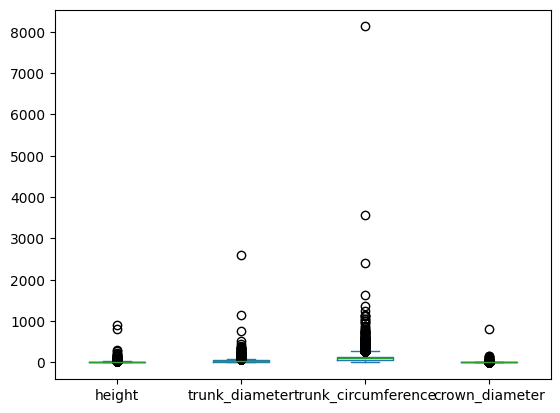

In [66]:
# look for evidence of outliers
gdf[['height','trunk_diameter','trunk_circumference','crown_diameter']].plot.box()

In [67]:
# set SD limit
numsd = 3

<Axes: ylabel='Frequency'>

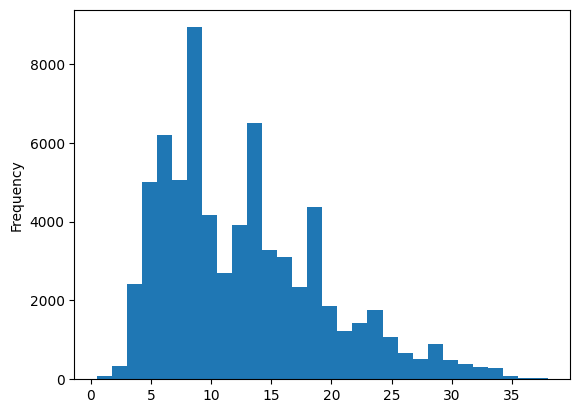

In [68]:
# we subset by trees whose height within four standard deviations of the mean height
# Note: The tallest tree in Germany is about 68 meters.
# Trees taller than that are excluded.
smpsd = gdf['height'].std()
smpmean = gdf['height'].mean()
limit = smpmean+(smpsd*numsd)
mask_height = gdf['height'] <= limit
gdf['height'][mask_height].plot.hist(bins=30)

<Axes: ylabel='Frequency'>

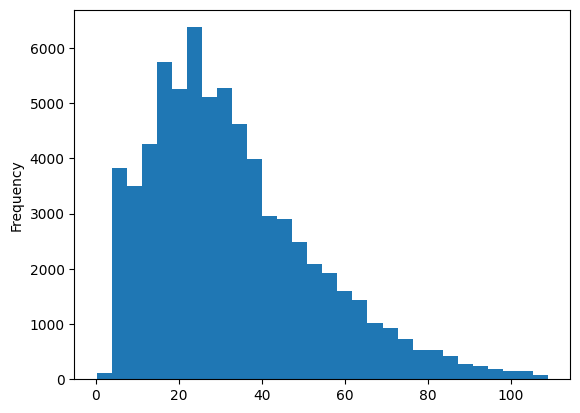

In [69]:
# we subset by trees whose trunk_diameter is within four standard deviations of the mean trunk_diameter
smpsd = gdf['trunk_diameter'].std()
smpmean = gdf['trunk_diameter'].mean()
limit = smpmean+(smpsd*numsd)
mask_trunk_diameter = gdf['trunk_diameter'] <= limit
gdf['trunk_diameter'][mask_trunk_diameter].plot.hist(bins=30)

<Axes: ylabel='Frequency'>

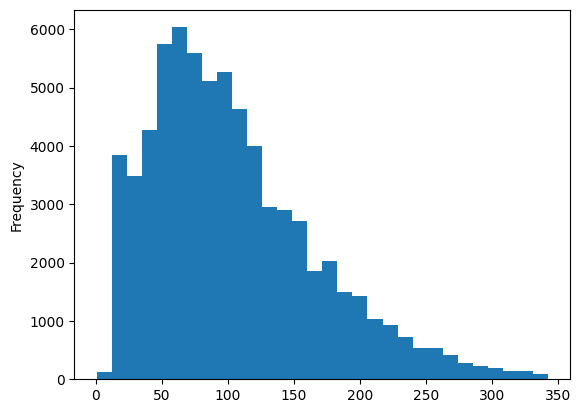

In [70]:
# we subset by trees whose trunk_circumference is within four standard deviations of the mean trunk_circumference
smpsd = gdf['trunk_circumference'].std()
smpmean = gdf['trunk_circumference'].mean()
limit = smpmean+(smpsd*numsd)
mask_trunk_circumference = gdf['trunk_circumference'] <= limit
gdf['trunk_circumference'][mask_trunk_circumference].plot.hist(bins=30)

<Axes: ylabel='Frequency'>

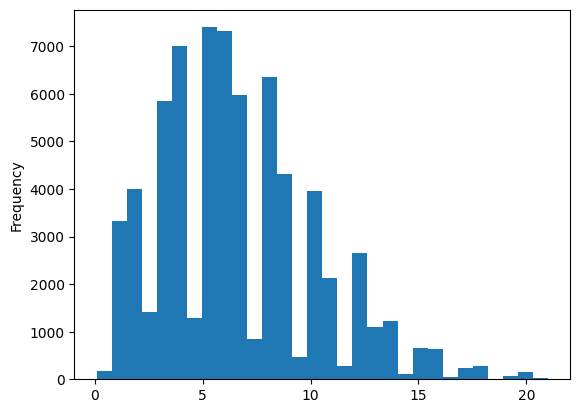

In [71]:
# we subset by trees whose crown_diameter is within four standard deviations of the mean crown_diameter
smpsd = gdf['crown_diameter'].std()
smpmean = gdf['crown_diameter'].mean()
limit = smpmean+(smpsd*numsd)
mask_crown_diameter = gdf['crown_diameter'] <= limit
gdf['crown_diameter'][mask_crown_diameter].plot.hist(bins=30)

<Axes: >

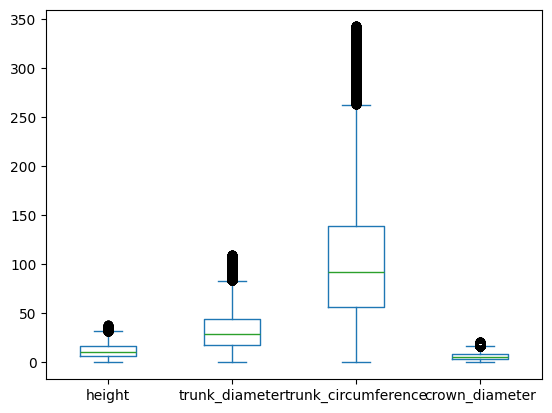

In [72]:
# generate a uniform mask that excludes outliers across all continuious variables
# Note: we do not drop these units, as these are still trees and may contribute to a future competitive density feature
mask_non_outlier = mask_height & mask_trunk_diameter & mask_trunk_circumference & mask_crown_diameter
gdf.loc[mask_non_outlier,['height','trunk_diameter','trunk_circumference','crown_diameter']].plot.box()

In [73]:
# isolate cohorts for analysis that are not outliers and have less than n units 
min_count = 50
# counts by species of non outliers.
non_outlier_counts = gdf[mask_non_outlier].groupby('botanical_species_formal_name')['botanical_species_formal_name'].count()

In [74]:
# list of cohorts that meet minimum representation
valid_species = non_outlier_counts[non_outlier_counts > min_count].index.to_list()
list_printer(valid_species)

            Abies grandis             |            Acer campestre            
            Acer negundo              |           Acer platanoides           
         Acer pseudoplatanus          |              Acer rubrum             
          Acer saccharinum            |        Aesculus hippocastanum        
          Aesculus x carnea           |        Ahorn-Laub-Mischbestand       
         Ailanthus altissima          |            Alnus glutinosa           
            Alnus incana              |            Betula pendula            
            Betula utilis             |        Buchen-Eichen-Mischwald       
          Carpinus betulus            |            Castanea sativa           
      Chamaecyparis lawsoniana        |            Corylus colurna           
         Crataegus laevigata          |          Crataegus lavallei          
         Crataegus monogyna           |            Fagus sylvatica           
         Fraxinus excelsior           |            Fraxinus ornu

In [75]:
# mark those records whoes species cohort meets minimum representation...
gdf['qualified_species_representation'] = gdf['botanical_species_formal_name'].isin(valid_species)
# ... and that do not contain outliers.
gdf['in_qualified_cohort'] = gdf['botanical_species_formal_name'].isin(valid_species) & mask_non_outlier
# describe subset
gdf[gdf['in_qualified_cohort']].describe()

,height,trunk_diameter,trunk_circumference,crown_diameter
count,53777.000000,53777.000000,53777.000000,53777.000000
mean,12.424886,32.873602,103.275459,6.464168
std,6.379131,19.407620,60.970927,3.555929
min,0.500000,0.270000,0.850000,0.100000
25%,7.000000,18.000000,56.550000,4.000000
50%,11.000000,29.280000,92.000000,6.000000
75%,16.000000,44.000000,138.230000,8.900000
max,38.000000,109.000000,342.430000,21.000000


<Axes: >

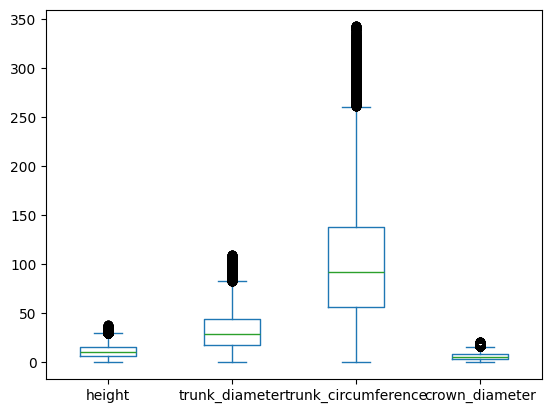

In [76]:
# reexamine key variables in qualified subset
gdf[['height','trunk_diameter','trunk_circumference','crown_diameter']][gdf['in_qualified_cohort']].plot.box()

array([[<Axes: xlabel='height', ylabel='height'>,
        <Axes: xlabel='trunk_diameter', ylabel='height'>,
        <Axes: xlabel='trunk_circumference', ylabel='height'>,
        <Axes: xlabel='crown_diameter', ylabel='height'>],
       [<Axes: xlabel='height', ylabel='trunk_diameter'>,
        <Axes: xlabel='trunk_diameter', ylabel='trunk_diameter'>,
        <Axes: xlabel='trunk_circumference', ylabel='trunk_diameter'>,
        <Axes: xlabel='crown_diameter', ylabel='trunk_diameter'>],
       [<Axes: xlabel='height', ylabel='trunk_circumference'>,
        <Axes: xlabel='trunk_diameter', ylabel='trunk_circumference'>,
        <Axes: xlabel='trunk_circumference', ylabel='trunk_circumference'>,
        <Axes: xlabel='crown_diameter', ylabel='trunk_circumference'>],
       [<Axes: xlabel='height', ylabel='crown_diameter'>,
        <Axes: xlabel='trunk_diameter', ylabel='crown_diameter'>,
        <Axes: xlabel='trunk_circumference', ylabel='crown_diameter'>,
        <Axes: xlabel='crown_di

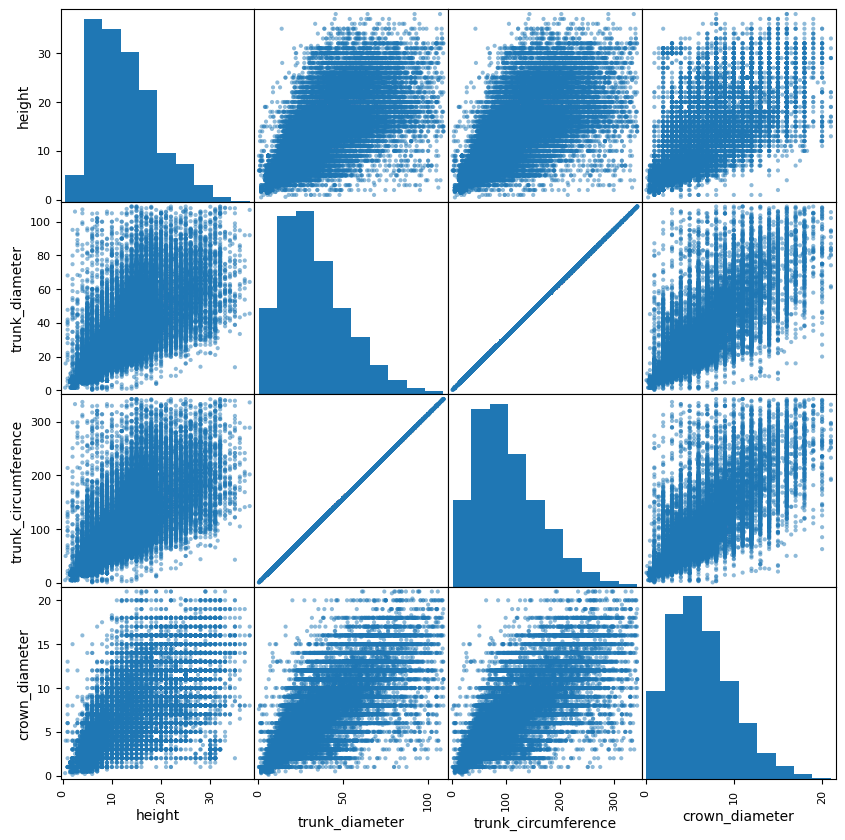

In [77]:
# matrix plot of qualified subset
data_subset = gdf[['height','trunk_diameter','trunk_circumference','crown_diameter']][gdf['in_qualified_cohort']]
scatter_matrix(data_subset, figsize=(10,10),)